# Data demo

This notebook explains how to use our data with a minimal example of rendering some humans. The NeRF code for rendering is also included.

In [1]:
# import various modules
%load_ext autoreload
%autoreload 2

import copy
import json
import os
import random
from pprint import pprint

import mediapy as media
import numpy as np
import smplx
import torch
import trimesh
from tqdm import tqdm

# some custom code
from sitcoms3D.utils.dataloader import human_to_nerf_space, load_colmap_cameras_from_sitcom_location
from sitcoms3D.utils.render_utils import render_human, NeRFWrapper
from sitcoms3D.nerf.run_train import NeRFSystem
from sitcoms3D.utils.io import load_from_json
from sitcoms3D.nerf.src.opt import get_opts_from_args_str
from sitcoms3D.nerf.utils.visualization import composite

Choose which sitcom location to use

In [2]:

sit_locs = sorted(os.listdir("../data/sparse_reconstruction_and_nerf_data"))
print("These are the sitcom locations available:")
pprint(sit_locs)

# sitcom_location = sit_locs[0]
sitcom_location = "Friends-monica_apartment"
print("\nGoing to use sitcom location:", sitcom_location)

These are the sitcom locations available:
['ELR-apartment',
 'Frasier-apartment',
 'Friends-monica_apartment',
 'HIMYM-red_apartment',
 'Seinfeld-jerry_living_room',
 'TAAHM-kitchen',
 'TBBT-big_living_room']

Going to use sitcom location: Friends-monica_apartment


In [3]:
ckpt_path = f"../data/nerf_checkpoints/{sitcom_location}.ckpt"
environment_dir = f"data/sparse_reconstruction_and_nerf_data/{sitcom_location}"
nerf_wrapper = NeRFWrapper(environment_dir, ckpt_path)

<hr>

# Load NeRF information

Load the cameras.json file. This json file is a processed version of the colmap/*.bin files and contains information only for images used for NeRF.
The 'frames' field contains camera poses that have been transformed from COLMAP into something axis-aligned for NeRF.
'frames' is obtained by (NERF camera poses = 'point_cloud_transform' @ COLMAP camera poses) / 'scale_factor'.
You can open the threejs.json file at https://threejs.org/editor/ to see the point cloud after the transform but before
the scale factor is applied.
Note that 'scale_factor' is applied to the camera poses for scaling the scene to something suitable for NeRF.

In [4]:
cameras = load_from_json(f"../data/sparse_reconstruction_and_nerf_data/{sitcom_location}/cameras.json")
pprint(list(cameras.keys()))
print("Number of images used to train NeRF:", len(cameras["frames"]))

['bbox', 'point_cloud_transform', 'scale_factor', 'frames']
Number of images used to train NeRF: 167


In [5]:
print(cameras['frames'][0])

{'image_name': 'Friends_S08E02_00006008.jpg', 'intrinsics': [[2530.2216796875, 0.0, 960.0], [0.0, 2530.2216796875, 540.0], [0.0, 0.0, 1.0]], 'camtoworld': [[-0.9634050348760698, -0.040992621642138266, 0.2648968549196904, -0.05025557209602584], [-0.0041703600584286965, 0.9904097778337966, 0.13809808133422116, 0.4282250650592982], [-0.268017437627521, 0.13193967160075318, -0.9543367205475555, -1.5701499293456418], [0.0, 0.0, 0.0, 1.0]]}


In [6]:
# Show the camera information, which is in the NeRF space.
# It has already been transformed from the COLMAP space to
# something axis-aligned for NeRF.
nerf_image_name_to_info = {}
for dict_ in cameras["frames"]:
    nerf_image_name_to_info[dict_["image_name"]] = {
        "intrinsics": np.array(dict_["intrinsics"]),
        "camtoworld": np.array(dict_["camtoworld"]),
    }

# choose a random image to work with
image_name = random.choice(list(nerf_image_name_to_info.keys()))
print("Showing camera information for image:", image_name)
pprint(nerf_image_name_to_info[image_name])

Showing camera information for image: Friends_S08E09_00009340.jpg
{'camtoworld': array([[-0.25043062, -0.07192863,  0.96545884,  1.05304116],
       [ 0.01690437,  0.99675932,  0.07864541,  0.53909318],
       [-0.96798696,  0.03601569, -0.24840314,  0.10903725],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'intrinsics': array([[2.72643213e+03, 0.00000000e+00, 9.60000000e+02],
       [0.00000000e+00, 2.72643213e+03, 5.40000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}


# Load COLMAP information

In [7]:
# Load from the COLMAP data to get information for all the cameras.
# this may take a while...
basedir = f"../data/sparse_reconstruction_and_nerf_data/{sitcom_location}"
colmap_image_name_to_info = load_colmap_cameras_from_sitcom_location(basedir)

Next, we show how to transform the COLMAP cameras into the NeRF space shown above.

In [8]:
print("Showing camera information for image in COLMAP SPACE:", image_name)
pprint(colmap_image_name_to_info[image_name])

# apply the transform to move back into the NERF SPACE
assert np.array_equal(nerf_image_name_to_info[image_name]["intrinsics"],
                      colmap_image_name_to_info[image_name]["intrinsics"])

camtoworld = copy.deepcopy(colmap_image_name_to_info[image_name]["camtoworld"])
camtoworld[..., 1:3] *= -1 # flip the rotation convention for the camera

# unpack relevant data
point_cloud_transform = np.array(cameras["point_cloud_transform"])
scale_factor = np.array(cameras["scale_factor"])

camtoworld = point_cloud_transform @ camtoworld
camtoworld[:3, 3] /= scale_factor # only scale the translation of the camera
print("Showing camera information for image in NERF SPACE:", image_name)
pprint(camtoworld)

# now we've transformed the COLMAP camera to the NERF space
# and the camera poses are equal
assert np.array_equal(nerf_image_name_to_info[image_name]["camtoworld"],
                      camtoworld)


Showing camera information for image in COLMAP SPACE: Friends_S08E09_00009340.jpg
{'camtoworld': array([[ 0.99974526,  0.01281507, -0.01857947, -0.67446615],
       [-0.01358666,  0.99902457, -0.04201568,  0.21656005],
       [ 0.01802292,  0.04225741,  0.99894419, -1.32194691],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'intrinsics': array([[2.7264321e+03, 0.0000000e+00, 9.6000000e+02],
       [0.0000000e+00, 2.7264321e+03, 5.4000000e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)}
Showing camera information for image in NERF SPACE: Friends_S08E09_00009340.jpg
array([[-0.25043062, -0.07192863,  0.96545884,  1.05304116],
       [ 0.01690437,  0.99675932,  0.07864541,  0.53909318],
       [-0.96798696,  0.03601569, -0.24840314,  0.10903725],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])


AssertionError: 

# Visualize humans

Now that we understand the cameras, we can load smpl parameters and render from a camera pose.

In [13]:
print(image_name)
print(nerf_image_name_to_info[image_name]["camtoworld"])
print(camtoworld)
print(np.array_equal(nerf_image_name_to_info[image_name]["camtoworld"], camtoworld))
print(np.allclose(nerf_image_name_to_info[image_name]["camtoworld"], camtoworld))

Friends_S08E09_00009340.jpg
[[-0.25043062 -0.07192863  0.96545884  1.05304116]
 [ 0.01690437  0.99675932  0.07864541  0.53909318]
 [-0.96798696  0.03601569 -0.24840314  0.10903725]
 [ 0.          0.          0.          1.        ]]
[[-0.25043062 -0.07192863  0.96545884  1.05304116]
 [ 0.01690437  0.99675932  0.07864541  0.53909318]
 [-0.96798696  0.03601569 -0.24840314  0.10903725]
 [ 0.          0.          0.          1.        ]]
False
True


In [15]:
# the set of image names that we used for nerf
# these images are included in the sparse_reconstruction_and_nerf_data/ folder
nerf_image_names = set(nerf_image_name_to_info.keys())

# the set of image names that we have smpl parameters for
# this is wherever our method "calibrated multi-shot" was run
human_pairs = load_from_json(f"../data/human_pairs/{sitcom_location}.json")
image_name_to_shot_change_image_name = {}
calibrated_multishot_image_names = set()
for image_name_a, human_idx_a, image_name_b, human_idx_b in human_pairs:
    calibrated_multishot_image_names.add(image_name_a)
    calibrated_multishot_image_names.add(image_name_b)
    image_name_to_shot_change_image_name[image_name_a] = image_name_b
    image_name_to_shot_change_image_name[image_name_b] = image_name_a

image_names = nerf_image_names.intersection(calibrated_multishot_image_names)
print("Found {} images that are used for nerf and contain smpl parameters".format(len(image_names)))

# choose a random image name to work with and visualize
# image_name = random.choice(list(image_names))
image_name = "Friends_S08E18_00005507.jpg"

# read data for the image and a human...
human_data = load_from_json(f"../data/human_data/{sitcom_location}.json")

image_human_data = human_data[image_name]
print("going to visualize image {} with {} humans".format(image_name, len(image_human_data)))


Found 99 images that are used for nerf and contain smpl parameters
going to visualize image Friends_S08E18_00005507.jpg with 7 humans


Show the image that we are going to reconstruct the humans for

""

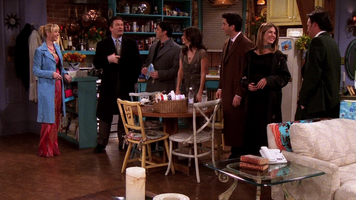

In [16]:
image = media.read_image(f"../data/sparse_reconstruction_and_nerf_data/{sitcom_location}/images/{image_name}")
media.show_image(image, height=200)

In [17]:
model_folder = "../data/smpl_models"
model_type = "smpl"
gender = "neutral"

In [18]:
body_model = smplx.create(model_folder,
                     model_type=model_type,
                     gender=gender)

In [19]:
def get_human_obj_mesh(image_name: str, human_idx: int):
    if "smpl" not in human_data[image_name][human_idx]:
        print(f"smpl values don't exist for {image_name} and human_idx {human_idx}")
        return None
    smpl_data = human_data[image_name][human_idx]["smpl"]
    print(smpl_data.keys())

    camera_translation = torch.tensor(smpl_data["camera_translation"])[None]
    betas = torch.tensor(smpl_data["betas"])[None]
    global_orient = torch.tensor(smpl_data["global_orient"])[None]
    body_pose = torch.tensor(smpl_data["body_pose"])[None]
    colmap_rescale = float(smpl_data["colmap_rescale"])

    output = body_model(
        betas=betas,
        global_orient=global_orient,
        body_pose=body_pose,
        return_verts=True)

    vertices = output.vertices + camera_translation
    pose_colmap = torch.from_numpy(colmap_image_name_to_info[image_name]["camtoworld"]).float()
    pose_colmap[:3,3] *= colmap_rescale
    # homogeneous coordinates
    vertices = torch.cat([vertices, torch.ones_like(vertices[..., 0:1])], dim=-1)
    vertices = vertices @ pose_colmap.T
    vertices = vertices[...,:3]

    out_mesh = trimesh.Trimesh(vertices[0].detach().numpy(), body_model.faces, process=False)
    human_obj_filename = "temp.obj"
    out_mesh.export(human_obj_filename);

    # specify the human to render
    obj_mesh_original = trimesh.load(human_obj_filename, process=False)
    obj_mesh = human_to_nerf_space(obj_mesh_original, point_cloud_transform, scale_factor, colmap_rescale)
    return obj_mesh

In [20]:
human_obj_meshes = []
for human_idx in range(len(image_human_data)):
    print("human_idx", human_idx)
    obj_mesh = get_human_obj_mesh(image_name, human_idx)
    if obj_mesh:
        human_obj_meshes.append(obj_mesh)

human_idx 0
smpl values don't exist for Friends_S08E18_00005507.jpg and human_idx 0
human_idx 1
smpl values don't exist for Friends_S08E18_00005507.jpg and human_idx 1
human_idx 2
smpl values don't exist for Friends_S08E18_00005507.jpg and human_idx 2
human_idx 3
dict_keys(['camera_translation', 'betas', 'global_orient', 'body_pose', 'colmap_rescale'])
human_idx 4
smpl values don't exist for Friends_S08E18_00005507.jpg and human_idx 4
human_idx 5
smpl values don't exist for Friends_S08E18_00005507.jpg and human_idx 5
human_idx 6
dict_keys(['camera_translation', 'betas', 'global_orient', 'body_pose', 'colmap_rescale'])


/home/yixing/anaconda3/envs/sitcoms/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Image we use for camera pose and intrinsics

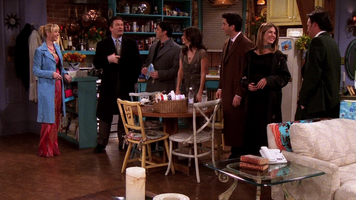

Image of humans rendered from this camera

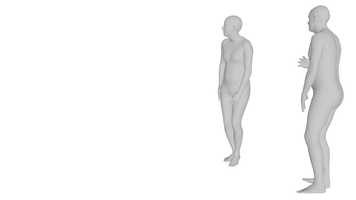

Composited image

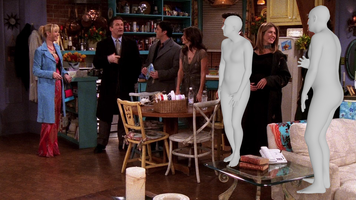

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Composited image with nerf

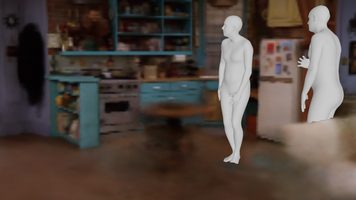

In [21]:
# render from the NeRF camera pose
def show_humans(human_obj_meshes, pose, K, image_name):
    image = media.read_image(f"../data/sparse_reconstruction_and_nerf_data/{sitcom_location}/images/{image_name}")
    color_h, depth_h, alpha_h = render_human(human_obj_meshes, pose, K)
    media.show_image(image, height=200, title="Image we use for camera pose and intrinsics")
    media.show_image(color_h, height=200, title="Image of humans rendered from this camera")
    composited = (color_h * alpha_h[...,None] + image * (1 - alpha_h[...,None])).astype("uint8")
    media.show_image(composited, height=200, title="Composited image")
    image_n, depth_n = nerf_wrapper(pose, K, height=200) # adjust height to get a higher resolution nerf rendering
    composited_with_nerf = composite(color_h, depth_h, image_n, depth_n, foreground_alpha=alpha_h, erode=None)
    media.show_image(composited_with_nerf, height=200, title="Composited image with nerf")

pose = nerf_image_name_to_info[image_name]["camtoworld"]
K = nerf_image_name_to_info[image_name]["intrinsics"]
show_humans(human_obj_meshes, pose, K, image_name) # image_name to read the background image

Now we show the humans from a novel camera pose. Note that the people won't match up, but you can imagine seeing them from the viewpoint of this next image. The real image can be swapped with NeRF for photorealism.

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Composited image with nerf

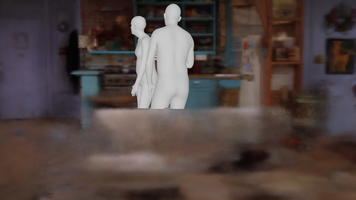

In [22]:
# now show the humans from a novel camera pose
# image_name_novel = random.choice(list(image_names))
image_name_novel = "Friends_S08E09_00007514.jpg"

pose = nerf_image_name_to_info[image_name_novel]["camtoworld"]
K = nerf_image_name_to_info[image_name_novel]["intrinsics"]
color_h, depth_h, alpha_h = render_human(human_obj_meshes, pose, K)
image_n, depth_n = nerf_wrapper(pose, K, height=200) # adjust height to get a higher resolution nerf rendering
composited_with_nerf = composite(color_h, depth_h, image_n, depth_n, foreground_alpha=alpha_h, erode=None)
media.show_image(composited_with_nerf, height=200, title="Composited image with nerf")